# core

> Module for the least squares model fit.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from dataclasses import dataclass
from scipy.stats import t
import typing


Create an instance of the class `CalibrationModel` by passing in the path to both your calibration data and your sample data. Next specify the name of your response variable and the nummber of test replicates you measured.

In [ ]:
sns.set_style("white")
sns.set_style("ticks")

In [ ]:
#| export
class CalibrationModel:

# TODO: think about adding replicates and no. of calibration points here or read it automatically from data

    def __init__(self, data, response_variable, test_replicates):
        self.raw_data = self.load_data(data)
        self.response_variable = response_variable
        self.fit = None
        self.test_replicates = test_replicates
        self.cal_line_points = self.raw_data.shape[0]
        self.r2 = None 

    def load_data(self, data):
        if ".csv" in data:
            raw_data = pd.read_csv(data)
        else:
            raw_data = data

        return raw_data


    

    def fit_ols(self):
        self.fit = smf.ols(f"{self.response_variable} ~ concentration", data=self.raw_data).fit()
        self.r2 = self.fit.rsquared
        # print(self.fit.summary())
        return self.fit 
    
    def get_params(self):
        slope = self.fit.params[1]
        intercept = self.fit.params[0]
        return slope, intercept
    
    def get_r2(self):
        return self.fit.rsquared
    
    def inverse_prediction(self, unknown: float):
        """Returns the concentration given the provided response variable."""
        slope, intercept = self.get_params()
        return (unknown - intercept)/slope
    
    def calculate_sse(self):
        return np.sum((self.fit.fittedvalues - self.raw_data[self.response_variable]) **2)
    
    def calculate_syx(self):
        return np.sqrt((self.calculate_sse())/(len(self.raw_data)-2))

    
    def get_t_value(self,alpha):
        return t.ppf(1 - alpha/2, self.fit.df_resid)

    def calculate_uncertainty(self):
        return self.calculate_sxhat() * self.get_t_value(0.05)
    
    def calculate_sxhat(self):
        return (self.calculate_syx() / self.fit.params[1]) * np.sqrt(1/ self.test_replicates + self.cal_line_points) 
    
    def fit_model(self):
        self.fit_ols()
        # self.plot_fit()
        self.get_params()
        self.get_r2()
        self.calculate_uncertainty()
        self.tabulate_results()

    
    def plot_fit(self):
        sns.regplot(x="concentration", y=self.response_variable, data=self.raw_data)
        sns.despine()
        sns.set_context("paper")
        plt.title(f"Calibration curve of concentration versus {self.response_variable}")
        plt.xlabel("Concentration") 
        plt.ylabel('Peak Value')
        plt.annotate(f"R-squared = {self.get_r2():.3f}", xy=(0.3, 0.8), xycoords='axes fraction', fontsize=9, ha='center', va='center')
        plt.annotate(f"Regression formula: y = {self.get_params()[0]:.3f} * x + {self.get_params()[1]:.3f}", xy=(0.3, 0.7), xycoords='axes fraction', fontsize=9, ha='center', va='center')
        plt.show()    

    def summary(self):
        """Provides a summary of the fitted model by plotting the data alongside the regression fit and printing the summary of the fit."""
        self.plot_fit()
        return self.fit.summary()
    

    def tabulate_results(self):
        print(f"Calibration curve of {self.response_variable} versus concentration")
        print(f"R2 = {self.r2}")
        print(f"Slope = {self.get_params()[0]}")
        print(f"Intercept = {self.get_params()[1]}")
        print(f"Uncertainity = {self.calculate_uncertainty()}")
        # print(f"Prediction = {self.inverse_prediction()}")
    

In [ ]:
import numpy as np
from scipy.stats import t

 

ws = 1
weights = np.ones(len(model.raw_data))

ybars = np.mean(unknown)
m = len(unknown)
n = len(model.raw_data)
df = n - 2

xi = model.raw_data['concentration']
yi = model.raw_data[model.response_variable]
yihat = model.fittedvalues

se = np.sqrt(np.sum(weights * (yi - yihat)**2) / df)


var_s = se**2 / ws

b1 = cal.fit.params[1]

ybarw = np.sum(weights * yi) / np.sum(weights)

# Adapted form of equation 8.28
sxhats = 1 / b1 * np.sqrt(
    (var_s / m) +
    se**2 * (1 / np.sum(weights) +
                (ybars - ybarw)**2 * np.sum(weights) /
                (b1**2 * (np.sum(weights) * np.sum(weights * xi**2) - np.sum(weights * xi)**2)))
)

b0 = cal.fit.params[0]

xs = (ybars - b0) / b1
t_val = t.ppf(1 - 0.5 * alpha, df)
conf = t_val * sxhats
conf


In [ ]:
# Example usage
from sklearn import linear_model
import pandas as pd

# Create a sample dataset
data = {'x': [1, 2, 3, 4, 5],
        'y': [2, 4, 5, 4, 6]}
df = pd.DataFrame(data)

# Fit a linear regression model
model = linear_model.LinearRegression()
model.fit(df[['x']], df['y'])

# Calculate the prediction interval
newdata = [7, 8, 9]  # New y values for prediction
alpha = 0.05

confidence = inverse_predict(model, newdata, alpha=alpha)

# Print the confidence interval for each new y value
for i in range(len(newdata)):
    print(f"Confidence interval for y={newdata[i]}: {confidence[i]}")


AttributeError: 'LinearRegression' object has no attribute 'model'

In [ ]:
model.

In [ ]:
#| export
# def plot_calibration_curves(models, unknown):
#     fig, ax = plt.subplots(2, 2, figsize=(10, 10))

#     for i, model in enumerate(models):
#         row = i // 2
#         col = i % 2

#         sns.regplot(x="concentration", y=f"{model.response_variable}", data=model.raw_data, ax=ax[row, col])
#         ax[row, col].annotate(f"Predicted value = {model.inverse_prediction(unknown):.2f}", xy=(0.5, 0.9), xycoords='axes fraction', fontsize=9, ha='center', va='center')
#         ax[row, col].axvline(x=model.inverse_prediction(unknown), color='red', linestyle='--')
#         ax[row, col].axvline(x=model.inverse_prediction(unknown) + model.calculate_uncertainty(), color='blue', linestyle='--')
#         ax[row, col].axvline(x=model.inverse_prediction(unknown) - model.calculate_uncertainty(), color='blue', linestyle='--')
#         ax[row, col].set_title('Calibration Curve')
#         ax[row, col].set_xlabel('Concentration (v/v%)')
#         ax[row, col].set_ylabel('Peak Value')
#         ax[row, col].annotate(f"R-squared = {model.get_r2():.3f}", xy=(0.5, 0.8), xycoords='axes fraction', fontsize=9, ha='center', va='center')
#         ax[row, col].annotate(f"Regression formula: y = {model.get_params()[0]:.3f} * x + {model.get_params()[1]:.3f}", xy=(0.5, 0.7), xycoords='axes fraction', fontsize=9, ha='center', va='center')

#     plt.tight_layout()
#     plt.show()

In [ ]:
def generate_test_data(slope, intercept):
        x = np.linspace(1, 10, num=5)
        y = intercept + x * slope
        df = pd.DataFrame({'concentration': x, "abs": y})
        return df

def generate_sample_data():
    x = np.array(['unknown1', 'unknown2'])
    y = np.array([13.75, 20.50])
    df = pd.DataFrame({'sample': x, "abs": y})
    df = df.set_index('sample')
    return df


test_data = generate_test_data(3, 4)
sample_data = generate_sample_data()



In [ ]:
cal = CalibrationModel(data = test_data, response_variable = "abs", test_replicates = 1)
cal.fit_model()

Calibration curve of abs versus concentration
R2 = 1.0
Slope = 3.000000000000001
Intercept = 3.9999999999999964
Uncertainity = 6.662313258790483e-15


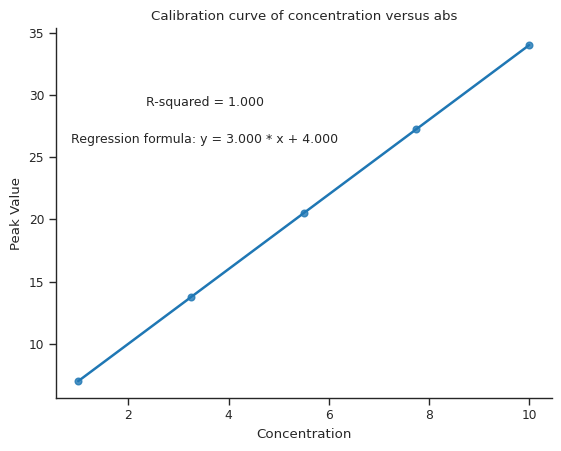

/home/rhysmcalister/mambaforge/envs/myenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    abs   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.931e+31
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           3.82e-48
Time:                        07:52:19   Log-Likelihood:                 162.17
No. Observations:                   5   AIC:                            -320.3
Df Residuals:                       3   BIC:                            -321.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.0000   2.29e-15   1.75e+15      0.000       4.000       4.000
concentration     3.0000    3.6e-16   8.33e+15      0.000       3.000       3.000
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.640
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.176
Skew:                          -0.400   Prob(JB):                        0.916
Kurtosis:                       2.548   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
cal.summary()

## Tests

A couple of quick tests to make sure nothing is broken. 

In [ ]:
assert cal.inverse_prediction(13.75) == 3.25


In [ ]:
assert cal.inverse_prediction(20.5) == 5.5

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()